In [36]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics
#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
autism_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/Autism-Adult-Data.csv',sep= ',', header= 0)

In [37]:
print ("Dataset Lenght:: ", len(autism_data))
print ("Dataset Shape:: ", autism_data.shape)
#autism_data.sample(50)


print ("Rows     : " ,autism_data.isnull().shape[0])
print ("Columns  : " ,autism_data.isnull().shape[1])
print ("\nMissing values :  ", autism_data.isnull().sum().values.sum())



Dataset Lenght::  704
Dataset Shape::  (704, 22)
Rows     :  704
Columns  :  22

Missing values :   0


In [38]:
#replace ? with NaN
autism_data = autism_data.replace('?', np.nan)
autism_data.head()

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,1,0,0,1,1,0,...,f,White-European,no,no,United States,no,6,18 and more,Self,NO
1,2,1,1,0,1,0,0,0,1,0,...,m,Latino,no,yes,Brazil,no,5,18 and more,Self,NO
2,3,1,1,0,1,1,0,1,1,1,...,m,Latino,yes,yes,Spain,no,8,18 and more,Parent,YES
3,4,1,1,0,1,0,0,1,1,0,...,f,White-European,no,yes,United States,no,6,18 and more,Self,NO
4,5,1,0,0,0,0,0,0,1,0,...,f,White-European,no,no,Egypt,no,2,18 and more,NaN,NO


In [39]:
autism_check_missing = (autism_data.isnull()).sum()
autism_check_missing

id                  0
A1_Score            0
A2_Score            0
A3_Score            0
A4_Score            0
A5_Score            0
A6_Score            0
A7_Score            0
A8_Score            0
A9_Score            0
A10_Score           0
age                15
gender              0
ethnicity           0
jundice             0
austim              0
contry_of_res       0
used_app_before     0
result              0
age_desc            0
relation           95
Class/ASD           0
dtype: int64

In [40]:
#remove column 'fnlwgt' because it's not strongly connected to protected attributes
#autism_data = autism_data.drop("fnlwgt", axis=1)
#autism_data = autism_data.drop("capital.gain", axis=1)

In [41]:
#delete columns with missing values
autism_data = autism_data.drop("age", axis =1)
autism_data = autism_data.drop("relation", axis =1)

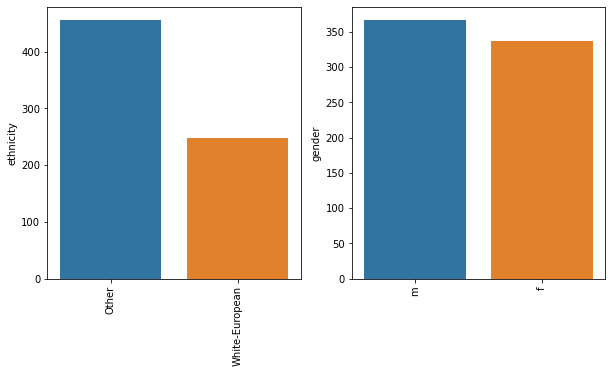

In [48]:
#plot the categorical count of each protected category
lis2 = ['ethnicity', 'gender']
plt.subplots(figsize=(10, 5))
index = 1
  
for col in lis2:
    y = autism_data[col].value_counts()
    plt.subplot(1, 2, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [47]:
# rename the other values except White value in race column for future use
autism_data['ethnicity']= autism_data['ethnicity'].replace(['Black','Asian','Middle-Eastern','Middle Eastern ','Middle Eastern','Pasifika', 'others','South Asian', 'Latino', 'Turkish','Hispanic','Others'], 'Other')
autism_data.head(20)

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,Class/ASD
0,1,1,1,1,1,0,0,1,1,0,0,f,White-European,no,no,United States,no,6,18 and more,NO
1,2,1,1,0,1,0,0,0,1,0,1,m,Other,no,yes,Brazil,no,5,18 and more,NO
2,3,1,1,0,1,1,0,1,1,1,1,m,Other,yes,yes,Spain,no,8,18 and more,YES
3,4,1,1,0,1,0,0,1,1,0,1,f,White-European,no,yes,United States,no,6,18 and more,NO
4,5,1,0,0,0,0,0,0,1,0,0,f,White-European,no,no,Egypt,no,2,18 and more,NO
5,6,1,1,1,1,1,0,1,1,1,1,m,Other,yes,no,United States,no,9,18 and more,YES
6,7,0,1,0,0,0,0,0,1,0,0,f,Other,no,no,United States,no,2,18 and more,NO
7,8,1,1,1,1,0,0,0,0,1,0,m,White-European,no,no,New Zealand,no,5,18 and more,NO
8,9,1,1,0,0,1,0,0,1,1,1,m,White-European,no,no,United States,no,6,18 and more,NO
9,10,1,1,1,1,0,1,1,1,1,0,m,Other,yes,yes,Bahamas,no,8,18 and more,YES


In [49]:
# select all categorical variables
autism_data_categorical = autism_data.select_dtypes(include=['object'])
autism_data_categorical.head()

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
0,f,White-European,no,no,United States,no,18 and more,NO
1,m,Other,no,yes,Brazil,no,18 and more,NO
2,m,Other,yes,yes,Spain,no,18 and more,YES
3,f,White-European,no,yes,United States,no,18 and more,NO
4,f,White-European,no,no,Egypt,no,18 and more,NO


In [50]:
# apply Label Encoder to categorical values
le = preprocessing.LabelEncoder()
autism_data_categorical = autism_data_categorical.apply(le.fit_transform)
autism_data_categorical.head()

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
0,0,1,0,0,64,0,0,0
1,1,0,0,1,13,0,0,0
2,1,0,1,1,56,0,0,1
3,0,1,0,1,64,0,0,0
4,0,1,0,0,22,0,0,0


In [51]:
#first, Drop earlier duplicate columns which had categorical values and concat eith new labelled categories (mean-mode function)
#autism_data_mode = autism_mode.drop(autism_data_categorical.columns,axis=1)
#autism_data_mode = pd.concat([autism_data_mode,autism_data_categorical],axis=1)
#autism_data_mode.head(10)

#first, Drop earlier duplicate columns which had categorical values and concat with new labelled categories (cd function)
autism_data = autism_data.drop(autism_data_categorical.columns,axis=1)
autism_data = pd.concat([autism_data,autism_data_categorical],axis=1)
autism_data.head(10)

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
0,1,1,1,1,1,0,0,1,1,0,0,6,0,1,0,0,64,0,0,0
1,2,1,1,0,1,0,0,0,1,0,1,5,1,0,0,1,13,0,0,0
2,3,1,1,0,1,1,0,1,1,1,1,8,1,0,1,1,56,0,0,1
3,4,1,1,0,1,0,0,1,1,0,1,6,0,1,0,1,64,0,0,0
4,5,1,0,0,0,0,0,0,1,0,0,2,0,1,0,0,22,0,0,0
5,6,1,1,1,1,1,0,1,1,1,1,9,1,0,1,0,64,0,0,1
6,7,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,64,0,0,0
7,8,1,1,1,1,0,0,0,0,1,0,5,1,1,0,0,43,0,0,0
8,9,1,1,0,0,1,0,0,1,1,1,6,1,1,0,0,64,0,0,0
9,10,1,1,1,1,0,1,1,1,1,0,8,1,0,1,1,9,0,0,1


In [14]:
#Pearson correlations
pearson = autism_data.corr(method = 'pearson')
pearson

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
id,1.000000,0.066290,0.047746,0.032943,0.012728,0.037583,-0.060366,0.043043,-0.035348,0.012815,0.017795,0.034795,0.018700,-0.059918,0.074202,-0.067220,0.003827,0.035746,NaN,0.039737
A1_Score,0.066290,1.000000,0.011539,0.074096,0.127814,0.169369,0.110199,0.217538,0.147640,0.145452,0.118413,0.397454,-0.075011,0.094097,-0.019077,0.097630,0.024271,-0.040620,NaN,0.297628
A2_Score,0.047746,0.011539,1.000000,0.223921,0.158998,0.153821,0.185864,-0.041768,0.035408,0.205421,0.068883,0.392540,-0.047393,0.169634,0.112615,0.074555,0.142462,-0.009645,NaN,0.311382
A3_Score,0.032943,0.074096,0.223921,1.000000,0.412722,0.264927,0.268846,0.078216,0.017771,0.315113,0.168454,0.552356,0.000795,0.175996,0.061760,0.113697,0.054094,0.055320,NaN,0.441074
A4_Score,0.012728,0.127814,0.158998,0.412722,1.000000,0.306806,0.295152,0.151236,0.008617,0.327673,0.210968,0.586025,-0.056508,0.198434,0.064918,0.193820,0.046927,0.023071,NaN,0.469945
A5_Score,0.037583,0.169369,0.153821,0.264927,0.306806,1.000000,0.392354,0.238589,0.102086,0.396582,0.267561,0.639706,-0.039688,0.079456,0.034378,0.090009,-0.019358,0.000374,NaN,0.537004
A6_Score,-0.060366,0.110199,0.185864,0.268846,0.295152,0.392354,1.000000,0.175489,0.100123,0.479422,0.294435,0.630012,-0.083615,0.183801,0.078366,0.114048,-0.010930,0.087378,NaN,0.592091
A7_Score,0.043043,0.217538,-0.041768,0.078216,0.151236,0.238589,0.175489,1.000000,0.085403,0.189480,0.252107,0.454848,0.061900,0.021547,0.030850,-0.008610,-0.017262,-0.022505,NaN,0.351429
A8_Score,-0.035348,0.147640,0.035408,0.017771,0.008617,0.102086,0.100123,0.085403,1.000000,0.101733,0.100782,0.324020,0.064127,-0.027676,0.012101,0.034845,-0.044392,-0.041155,NaN,0.237161
A9_Score,0.012815,0.145452,0.205421,0.315113,0.327673,0.396582,0.479422,0.189480,0.101733,1.000000,0.283340,0.661205,0.006940,0.126705,0.057717,0.167644,-0.073850,0.049567,NaN,0.635576


<AxesSubplot:>

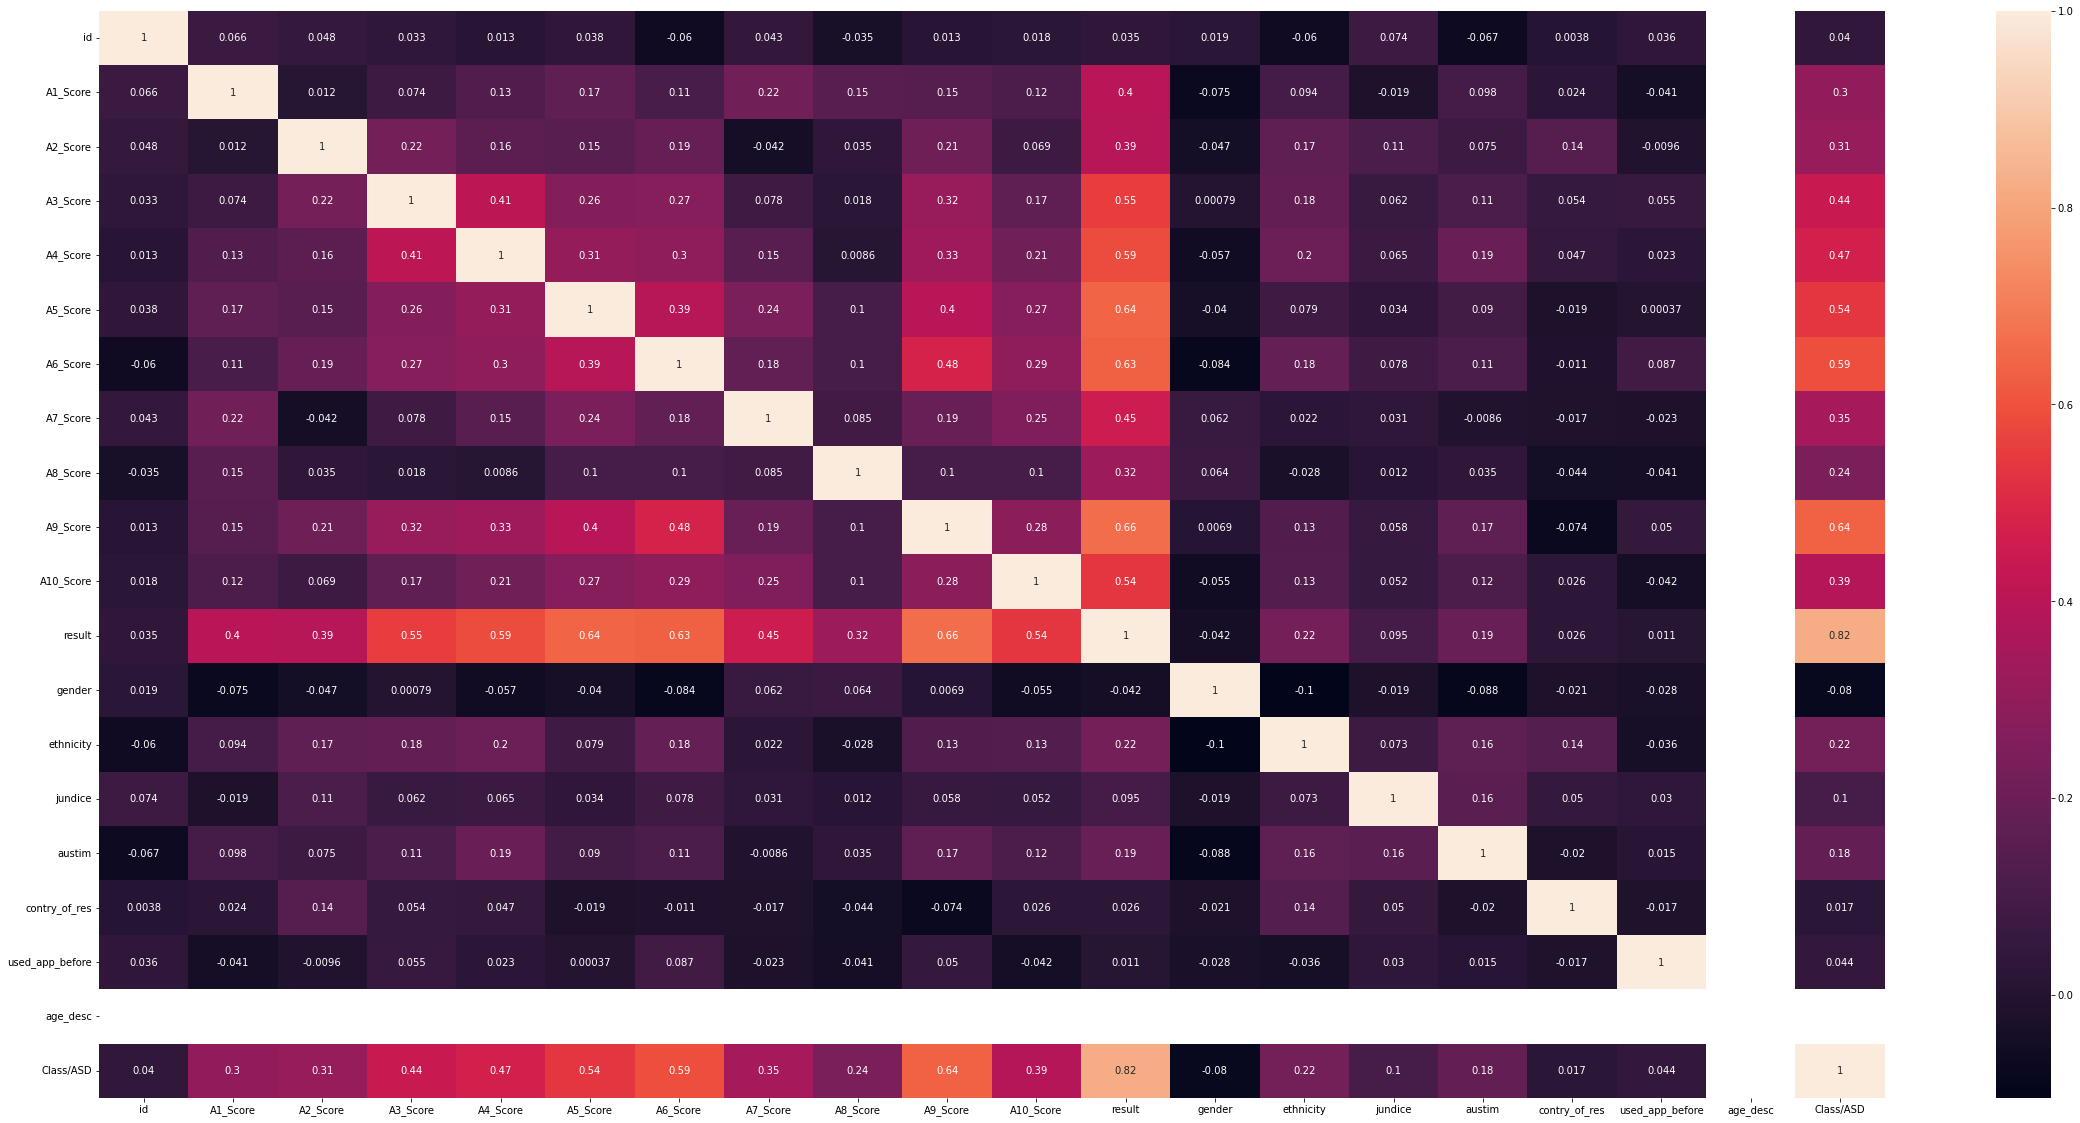

In [15]:
#create Heatmap 
plt.figure(figsize = (40,20))
sns.heatmap(pearson, annot = True)

In [52]:
target = autism_data.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=515, Percentage=73.153%
Class=1, Count=189, Percentage=26.847%


In [53]:
# convert target variable Class/ASD to categorical
autism_data['Class/ASD'] = autism_data['Class/ASD'].astype('category')

In [54]:
autism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               704 non-null    int64   
 1   A1_Score         704 non-null    int64   
 2   A2_Score         704 non-null    int64   
 3   A3_Score         704 non-null    int64   
 4   A4_Score         704 non-null    int64   
 5   A5_Score         704 non-null    int64   
 6   A6_Score         704 non-null    int64   
 7   A7_Score         704 non-null    int64   
 8   A8_Score         704 non-null    int64   
 9   A9_Score         704 non-null    int64   
 10  A10_Score        704 non-null    int64   
 11  result           704 non-null    int64   
 12  gender           704 non-null    int32   
 13  ethnicity        704 non-null    int32   
 14  jundice          704 non-null    int32   
 15  austim           704 non-null    int32   
 16  contry_of_res    704 non-null    int32   
 1

In [55]:
#MinMax scalling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(autism_data)
#X_test_scaled = scaler.transform(X_test)


In [56]:
autism = pd.DataFrame(scaled,columns = autism_data.columns)
#autism = pd.DataFrame(X_test,  columns = ["age","education","education.num","marital.status","relationship","race","sex","capital.gain","capital.loss","hours.per.week"])
autism.head(20)                    

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.6,0.0,1.0,0.0,0.0,0.969697,0.0,0.0,0.0
1,0.001422,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.5,1.0,0.0,0.0,1.0,0.196970,0.0,0.0,0.0
2,0.002845,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.8,1.0,0.0,1.0,1.0,0.848485,0.0,0.0,1.0
3,0.004267,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.6,0.0,1.0,0.0,1.0,0.969697,0.0,0.0,0.0
4,0.005690,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.2,0.0,1.0,0.0,0.0,0.333333,0.0,0.0,0.0
5,0.007112,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.9,1.0,0.0,1.0,0.0,0.969697,0.0,0.0,1.0
6,0.008535,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.969697,0.0,0.0,0.0
7,0.009957,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,1.0,1.0,0.0,0.0,0.651515,0.0,0.0,0.0
8,0.011380,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.6,1.0,1.0,0.0,0.0,0.969697,0.0,0.0,0.0
9,0.012802,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.8,1.0,0.0,1.0,1.0,0.136364,0.0,0.0,1.0


In [57]:
autism['Class/ASD']= autism['Class/ASD'].apply(np.int64)

In [58]:
# Putting independent variables/features to X
X = autism.drop('Class/ASD',axis=1)
# Putting response/dependent variable/feature to y
y = autism['Class/ASD']


In [ ]:
autism.head()

In [100]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

privileged_groups = [{'gender' :1}]
unprivileged_groups = [{'gender' :0}]

privileged_groups = [{'ethnicity' :1.0}]
unprivileged_groups = [{'ethnicity':0.0 }]

In [101]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= autism,
    label_names = ['Class/ASD'],
    protected_attribute_names=['gender'])

In [102]:
#SPD without classification
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.07130555712772582


In [90]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.071306


In [91]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is the best each time
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':range(2,20)}
dt_default = GridSearchCV(DecisionTreeClassifier(), tree_param)
dt_default.fit(X_train,y_train)

print('Best score: {}'.format(dt_default.best_score_))
print('Best parameters: {}'.format(dt_default.best_params_))


Best score: 1.0
Best parameters: {'criterion': 'gini', 'max_depth': 2}


In [92]:
#find the best parameters for the classifier and fit it to the data 
dt_best = DecisionTreeClassifier(criterion= 'gini', max_depth= 2)
dt_best.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [93]:
# making predictions
y_pred_default = dt_best.predict(X_test)
y_pred_default.shape

(176,)

In [94]:
# Printing classifier report after prediction
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))


Accuracy Score is: 1.0


In [95]:
#true negatives and true positives
tpr=np.sum((y_pred_default.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_pred_default.ravel()==1)
tnr=np.sum((y_pred_default.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_pred_default.ravel()==0)
# Printing accuracy
print("Accuracy score=",accuracy_score(y_test,y_pred_default))
print("True positive rate =",tpr)  
print("True negative rate =",tnr)

Accuracy score= 1.0
True positive rate = 1.0
True negative rate = 1.0


In [96]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
686,0.975818,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.5,1.0,1.0,0.0,0.0,0.969697,0.0,0.0,0
702,0.998578,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.6,1.0,0.0,0.0,0.0,0.712121,0.0,0.0,0
538,0.765292,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.4,0.0,1.0,0.0,0.0,0.969697,0.0,0.0,0
644,0.916074,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.6,1.0,0.0,1.0,0.0,0.651515,0.0,0.0,0
25,0.035562,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.3,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.362731,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.4,1.0,0.0,0.0,0.0,0.060606,0.0,0.0,0
394,0.560455,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.939394,0.0,0.0,0
625,0.889047,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.6,0.0,0.0,0.0,0.0,0.439394,0.0,0.0,0
533,0.758179,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.0,0.0,0.954545,0.0,0.0,1


In [97]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Class/ASD'],
    protected_attribute_names=['gender'])

In [98]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_default):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_default)

{'statistical_parity_difference': 0.07699334464309018}

In [99]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.076993


In [79]:
# list of models
models = [LogisticRegression(max_iter=500), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB()]

In [80]:
#function for comparing the accuracy of 4 classifiers after 10-fold cross validation
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=5)
    
    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy )
    print('----------------------------------------------')

In [81]:
#Execute the function
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=500) =   [1.         1.         1.         1.         0.99285714]
Accuracy % of the  LogisticRegression(max_iter=500) 99.86
----------------------------------------------
Cross Validation accuracies for  SVC(kernel='linear') =   [1. 1. 1. 1. 1.]
Accuracy % of the  SVC(kernel='linear') 100.0
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.94326241 0.9787234  0.95035461 0.97163121 0.92857143]
Accuracy % of the  KNeighborsClassifier() 95.45
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [1. 1. 1. 1. 1.]
Accuracy % of the  RandomForestClassifier() 100.0
----------------------------------------------
Cross Validation accuracies for  GaussianNB() =   [0.9787234  0.97163121 0.9787234  0.96453901 0.95      ]
Accuracy % of the  GaussianNB() 96.87
----------------------------------------------


In [103]:
#Train with the best classifier based on accuracy
from sklearn import model_selection
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [108]:
# Printing classifier report after prediction
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, rfc_predict)))


Accuracy Score is: 1.0


In [104]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
355,0.504979,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.530303,0.0,0.0,0
156,0.221906,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.4,0.0,0.0,0.0,0.0,0.863636,0.0,0.0,0
620,0.881935,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.4,1.0,0.0,0.0,0.0,0.439394,0.0,0.0,0
525,0.746799,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.4,0.0,0.0,0.0,0.0,0.954545,0.0,0.0,0
315,0.448080,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.3,1.0,0.0,0.0,0.0,0.939394,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.165007,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.8,0.0,1.0,0.0,0.0,0.969697,0.0,0.0,1
646,0.918919,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.545455,0.0,0.0,0
431,0.613087,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.984848,0.0,0.0,1
5,0.007112,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.9,1.0,0.0,1.0,0.0,0.969697,0.0,0.0,1


In [106]:
binaryLabelDataset3 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Class/ASD'],
    protected_attribute_names=['gender'])

In [107]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset3, rfc_predict):
    dataset_pred = binaryLabelDataset3.copy()
    dataset_pred.labels = rfc_predict
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset3, rfc_predict)

{'statistical_parity_difference': 0.13636363636363638}